# Downloading ESA Worldcover v200

This product: https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v200

In the second section we make it fit-for-purpose

## Load packages

In [ ]:
import os
import ee
import geemap
import warnings
import xarray as xr
import pandas as pd
import numpy as np
from odc.geo.xr import assign_crs

## Authenticate GEE    

In [ ]:
# Trigger the authentication flow.
# ee.Authenticate()

# Initialize the library.
ee.Initialize()

## Analysis parameters


In [ ]:
# product = 'MODIS/MCD43A4_006_NDVI'
product = 'ESA/WorldCover/v200'
bands = ['Map']
output_crs = "EPSG:3577"
resolution = 5000

# ~Aus region
region = ee.Geometry.Polygon([[
            [112,-43.0],
            [155,-43.0],
            [155,-9.0],
            [112,-9.0],
            [112,-43.0]]])


In [ ]:
ds = (ee.ImageCollection(product) 
  .map(lambda image: image.clip(region))
  .select(bands)
  .first()
     )
 
export = ee.batch.Export.image.toDrive(ds,
    description='ESA_WorldCover_v200',
    folder='landcover_datasets',
    region=region,
    scale=resolution,
    crs=output_crs,
    maxPixels=1e13,
    fileFormat='GeoTIFF',
    formatOptions={
        'cloudOptimized':True
          }
    )

export.start()

In [ ]:
export.status()

In [ ]:
# Using basemap in geemap
Map = geemap.Map(center=[-35.2041, 149.2721], zoom=4)


Map.addLayer(ds)
Map

## Tidy up dataset and intersect with GFASD cropland

In [1]:
import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import round_coords

import xarray as xr
import pandas as pd
import numpy as np
from odc.geo.xr import assign_crs
import distinctipy
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
ds = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_phenology/data/ESA_WorldCover_v200.tif').squeeze()
ds = assign_crs(ds, crs='EPSG:3577')

In [3]:
#reproject
ds_path = '/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-clim_gapfilled_1982_2013_0.2.0.nc'
gbox = assign_crs(xr.open_dataset(ds_path), crs='EPSG:4326').odc.geobox

ds = ds.odc.reproject(how=gbox,resampling='nearest')
ds = round_coords(ds)
ds = ds.rename('landcover')
ds = ds.where(ds>0) #remove nodata
ds = ds/10 #make 1,2,3 etc instead 10,20,30
ds = ds.where(ds!=8) #remove water
ds = ds.where(ds!=5) #remove urban
ds = xr.where(ds==9.5, 10, ds) #make mangroves a whole number

esa_crop = xr.where(ds==4,1,0)
ds = ds.where(ds!=4) #remove crops

In [4]:
crops = xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/croplands_5km.nc')['croplands']
crops = round_coords(crops)
rainfed_crops = xr.where(crops!=3, 0, 1) 
irrigated_crops = xr.where(crops!=2, 0, 1)
all_crop = (esa_crop | rainfed_crops | irrigated_crops)

ds = xr.where(ds==6, 4, ds) #mask sparse ==4
ds = xr.where(all_crop==1, 5, ds) #add combined cropping as a class
ds = xr.where(irrigated_crops==1, 6, ds) #add irrigated cropping as a class

# make numbering sequential
ds = xr.where(ds==9, 7, ds)
ds = xr.where(ds==10, 8, ds)

ds = ds.where(ds!=7) #remove wetalnds
ds = ds.where(ds!=8) #remove mangrove
# ds = xr.where(ds==11, 9, ds)

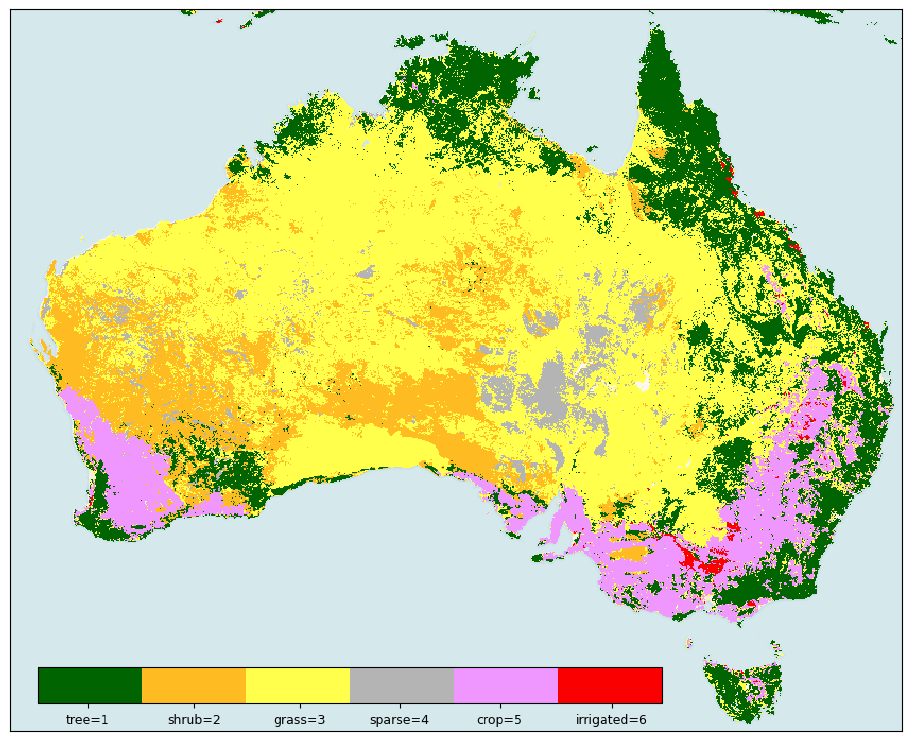

In [6]:
fig,ax = plt.subplots(1,1, figsize=(9,11), layout='constrained')

categories =['tree=1', 'shrub=2', 'grass=3', 'sparse=4', 'crop=5', 'irrigated=6'] #'wetlands', 'mangrove'
colors = ['#006400','#ffbb22', '#ffff4c', '#b4b4b4', '#f096ff', '#fa0000'] # '#0096a0', '#00cf75', 
        # 
cmap = LinearSegmentedColormap.from_list("landcover_cmap", colors, N=len(colors))

im = ds.plot(cmap=cmap, ax=ax, add_colorbar=False, add_labels=False)
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
axins1 = inset_axes(ax,width="70%",height="5%",loc="lower left", borderpad=2)
cbar = fig.colorbar(im, cax=axins1, ticks=[1.4, 2.25, 3.1, 3.9, 4.7, 5.6], orientation='horizontal')
cbar.ax.set_xticklabels(categories, fontsize=9);


## Export to file

In [15]:
ds.to_netcdf('/g/data/os22/chad_tmp/Aus_phenology/data/ESA_WorldCover_processed.nc')
